## OFDM Signal Processing

A complete **baseband receiver-side analysis** of an OFDM signal:

* Synchronization via energy threshold and correlation
* CP detection to validate symbol structure
* FFT demodulation for symbol extraction
* Visualization of constellation and power spectrum
* Subcarrier diagnostics for quality inspection

Unkown parameters: 

- CP length
- FFT length
- Symbol start index
 - Null subcarriers


This framework is valuable for evaluating **modulation integrity**, **timing accuracy**, and **subcarrier behavior** in both simulated and real-world OFDM systems.


### 1. **Signal Preprocessing**

* Load the received signal (input data)
* Define OFDM parameters:

  * Estimated symbol length
  * Estimated cyclic prefix
  * Total symbol length

### 2. **Autocorrelation for Rough Symbol Start**

* Compute autocorrelation of the received signal to identify repeating structure.
* Detect the **initial start index** of OFDM symbols based on energy thresholding.
* Use a moving window to refine this estimate.


### 3. **Cyclic Prefix (CP) Correlation-Based Detection**

* Sweep over candidate start indices around the rough estimate.
* For each, check the correlation between CP and end of symbols.
* Select the start index that gives the **maximum average CP correlation**.


### 4. **Downsampling and Multiple Tests**

* Optionally test different values of symbol scaling or downsampling factor

* Analyze resolution and robustness across symbol lengths.


### 5. **Symbol Extraction and FFT**

* From the chosen start index, extract all OFDM symbols.
* Remove the cyclic prefix from each.
* Perform FFT on each symbol to transform to the frequency domain.
* Apply `fftshift` to center the DC subcarrier.


### 6. **Constellation Plotting**

* Flatten all subcarriers from all symbols into a single array.
* Plot real vs. imaginary values of subcarriers to visualize:

  * Identify modulation type (e.g., QPSK, QAM)
  * Analyze signal quality and distortions

### 7. **Subcarrier Power Analysis**

* Calculate power per subcarrier for each symbol.
* Identify **low-power (null or attenuated)** subcarriers.
* Use `stem` plots to highlight which subcarriers fall below a threshold (e.g., power < threshold).
* Overplot known null subcarriers for verification.


### 8. **Focused Subcarrier Constellation**

* Extract only the **useful subcarriers**
* Discard DC or null subcarriers
* Flatten and visualize constellation from these active carriers.

---

# 1. Signal Preprocessing 

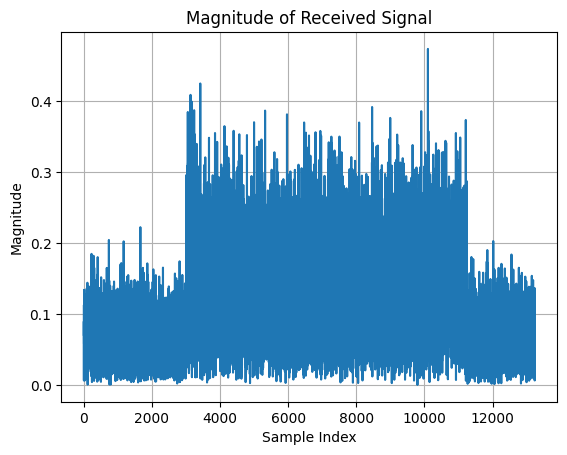

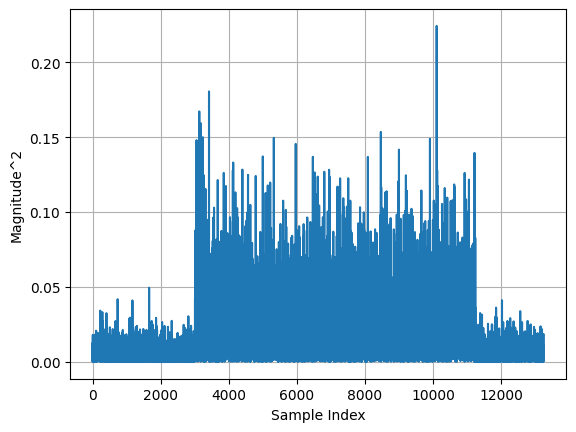

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

# Load the received signal

rx_signal = np.load('ofdm_rx_signal.npy')

# Received = scipy.io.loadmat('RxSignal.mat')
# print(Received.keys())
# rx_signal = Received['RxSignal']  
# rx_signal = rx_signal.squeeze()  # Convert (n,1) to (n,) if needed

plt.figure()
plt.plot(np.abs(rx_signal))  # Magnitude
plt.title('Magnitude of Received Signal')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.abs(rx_signal)**2)  # Magnitude
plt.xlabel('Sample Index')
plt.ylabel('Magnitude^2')
plt.grid(True)
plt.show()


## 2. Autocorrelation Analysis of Received Signal

Computing **autocorrelation** of the received signal to analyze its periodic structure and estimate symbol length.

### Autocorrelation Function

For a real-valued discrete signal $x[n]$, the autocorrelation function $R_{xx}[k]$ is defined as:

$$
R_{xx}[k] = \sum_{n} x[n] \cdot x[n+k]
$$

Where:

* $k$ is the **lag** (shift),
* For negative $k$, we evaluate $x[n] \cdot x[n - |k|]$,
* For normalization (`'coeff'`), we divide by the maximum value of $|R_{xx}[k]|$.

### Why Autocorrelation?

* Peaks in the autocorrelation function at non-zero lags can indicate **periodic patterns**.
* In digital communications, repeated symbol structures create peaks at multiples of **symbol length**.
* Here, a peak at lag = x, suggests the symbol duration is approximately **x samples**.


* Repeated peaks suggest periodicity in the received signal.
* If a peak occurs at lag ≈ x, it implies a **symbol duration** of x samples:


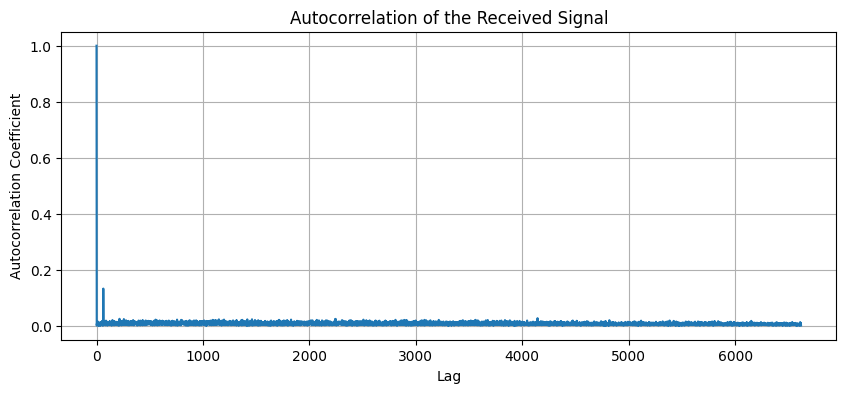

Detected peak lags: [  64  150  216  257  434  555  757  796 1093 1117 1150 1198 1316 1369
 1417 1461 1489 1715 1828 2070 2246 2508 2809 2891 3081 3216 3562 3677
 3838 4144]
Estimated Symbol Duration: 86 samples


In [37]:
from scipy.signal import find_peaks

N = len(rx_signal)
max_lag = N // 2 # floor(N/2) for considering positive lags only

# Compute autocorrelation using numpy
Rxx_full = np.correlate(rx_signal, rx_signal, mode='full')  # Full autocorrelation
lags = np.arange(-N + 1, N)
# Normalize 
Rxx_full = Rxx_full / np.max(np.abs(Rxx_full))

# Take only positive lags
mid_index = len(Rxx_full) // 2
Rxx_positive = Rxx_full[mid_index:(mid_index + max_lag + 1)]
lags_positive = lags[mid_index:(mid_index + max_lag + 1)]

plt.figure(figsize=(10, 4))
plt.plot(lags_positive, np.abs(Rxx_positive))
plt.title('Autocorrelation of the Received Signal')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')
plt.grid(True)
plt.show()

peaks, _ = find_peaks(np.abs(Rxx_positive), height=0.02, distance=20)

peak_lags = lags_positive[peaks]
print("Detected peak lags:", peak_lags)

# Only estimate if we have at least 2 peaks
if len(peak_lags) >= 2:
    symbol_duration_est = peak_lags[1] - peak_lags[0]
    print("Estimated Symbol Duration:", symbol_duration_est, "samples")
else:
    print("Not enough peaks found to estimate symbol duration.")





## Start Index Detection Based on Noise Threshold

The **start of the useful signal** in a received waveform based on power thresholding

- Estimate background noise power from the samples.
- Detect where the signal power significantly exceeds the noise.
- Mark and highlight a region around the detected start index.


### Noise Power Estimation

If roughly N samples are noisy samples at the beginning of received signal, then:

$$
P_{\text{noise}} = \frac{1}{N} \sum_{n=1}^{N} |x[n]|^2
$$

Where:

- \( x[n] \) is the received signal,
- \( |x[n]| \) is the magnitude (for complex signals).

### Threshold-Based Detection

We detect the **first index** where the signal power exceeds a multiple of the noise power:

$$
\text{start\_index} = \min \left\{ n : |x[n]|^2 > \text{Threshold} \cdot P_{\text{noise}} \right\}
$$



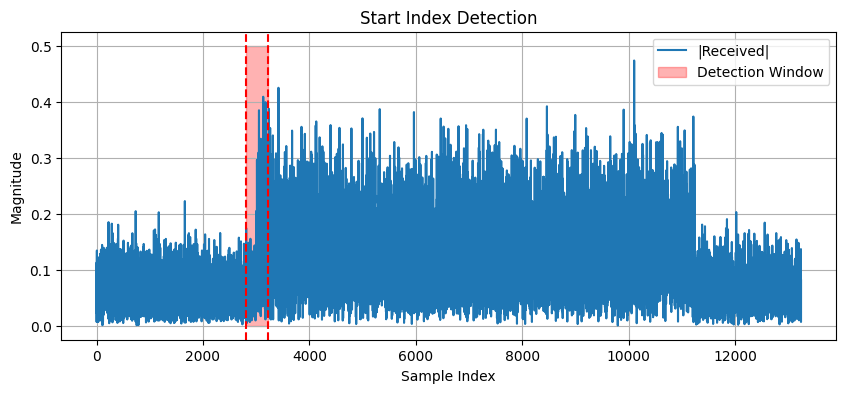

In [ ]:
noise1_power = np.mean(np.abs(rx_signal[:4000])**2) 
# 4000 is an arbitrary choice for noise estimation according the figure of received signal 
Threshold = 7 # the threshold factor is empirically chosen

# Find the start index where signal power exceeds noise threshold
ind = np.where(np.abs(rx_signal)**2 > Threshold * noise1_power)[0]
start_index = ind[0] if len(ind) > 0 else None

# Plot up to 5×start_index
plt.figure(figsize=(10, 4))
plt.plot(np.abs(rx_signal[:5*start_index]), label='|Received|')
plt.axvline(start_index - 200, color='r', linestyle='--')
plt.axvline(start_index + 200, color='r', linestyle='--')

# Shade the region from (start_index - 100) to (start_index + 100)
x_shade = [start_index - 200, start_index + 200, start_index + 200, start_index - 200]
y_shade = [0, 0, 0.5, 0.5]  # Adjust height if needed based on your signal

plt.fill(x_shade, y_shade, color='red', alpha=0.3, label='Detection Window')
plt.title("Start Index Detection")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()

# 3. Cyclic Prefix (CP) Correlation-Based Detection

Implementing a correlation-based search to **refine the start index** of an OFDM-like signal by detecting the **(CP)** structure within a predefined range.

To scan a window of possible start indices near the initial estimate and find the one that:

- Maximizes **CP autocorrelation**, indicating correct symbol alignment.
- Helps identify where **OFDM symbols** begin reliably.

### OFDM Symbol Structure

- Each symbol has a **cyclic prefix (CP)** prepended.
- CP is a copy of the last part of the symbol.
- This helps mitigate inter-symbol interference (ISI) and aids synchronization.

If  \(L_d\)  is the symbol length and \( L_{cp} \) is the CP length, the total symbol duration is:

$$
T_d = L_{cp} + L_d
$$



### CP Correlation Metric

To detect the symbol start, we compute the **correlation** between:

The **first \( L_{cp} \)** samples of the symbol, and  
The **last \( L_{cp} \)** samples of the same symbol.

$$
\text{Correlation}(L_{cp}) = \left| \sum_{n=0}^{L_{cp}-1} x[n] \cdot x^*[T_d - L_{cp} + n] \right|
$$

This is computed for several symbols and averaged across symbols to smooth the estimate.


### Algorithm Steps

1. **Scan candidate start indices** from `start_index - 100` to `start_index + 100`.

2. For each candidate `j`, extract the signal: `x = rx_signal[j:]`.

3. For each possible CP length \(L_{cp} \in [1, L_d/4]\):

    - Loop over 17 symbols (`i = 3` to `18`).
    - For each symbol, extract the CP and tail, then compute their correlation.


4. Store the **maximum average correlation** across CP lengths for each candidate index.

5. Identify the index with **maximum CP alignment**.


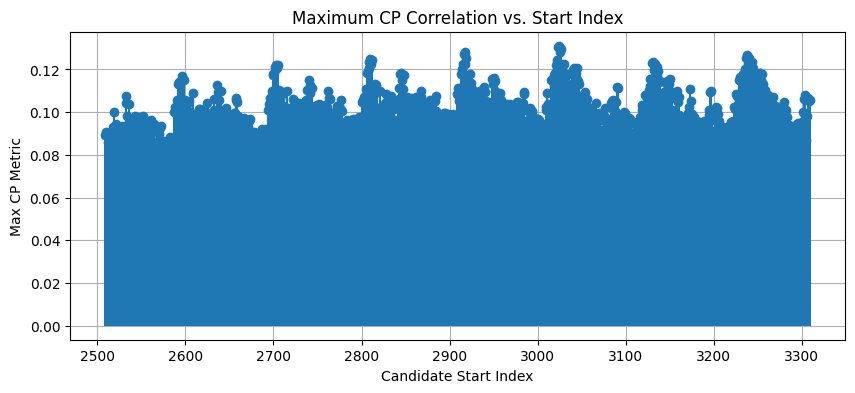

Best CP metric = 0.13 at index = 3024


In [ ]:
start_index = int(peak_lags[np.argmax(peak_lags > 2800)])  # pick one beyond the noise

# Step 2: Set search range around that
search_range = range(start_index - 300, start_index + 500)
mm = [] # maximum metric for CP
Ld = symbol_duration_est
Signal = rx_signal

for j in search_range:
    x = Signal[j:]
    c = np.zeros((Ld // 4, 16))  # Rows: possible CP lengths, Cols: symbols (3 to 18)

    for i in range(3, 19):  # symbol indices
        for cp_len in range(1, Ld // 4 + 1):
            Td = cp_len + Ld
            start = (i - 1) * Td
            end_ = i * Td
            if end_ > len(x):
                continue
            x1 = x[start:end_]
            c[cp_len - 1, i - 3] = np.abs(np.sum(np.conj(x1[:cp_len]) * x1[-cp_len:]))

    cp_avg = np.mean(c, axis=1)
    mm.append(np.max(cp_avg))

j_range = list(search_range)
mm = np.array(mm)

# Plot
plt.figure(figsize=(10, 4))
plt.stem(j_range, mm, linefmt='C0-', markerfmt='C0o', basefmt=" ")
plt.title("Maximum CP Correlation vs. Start Index")
plt.xlabel("Candidate Start Index")
plt.ylabel("Max CP Metric")
plt.grid(True)
plt.show()

# Best start
mm_max_idx = j_range[np.argmax(mm)]
print(f"Best CP metric = {np.max(mm):.2f} at index = {mm_max_idx}")


### Cyclic Prefix Estimation for Fixed Start Index

Examining the structure of an OFDM-like signal starting from a fixed `start_index = 398` to evaluate the correlation between the cyclic prefix and the end of each symbol.

- Detect if the signal exhibits repeated cyclic structure.
- Plot correlation metrics per symbol.
- Average correlation results to validate CP length estimation.

### Assumptions

- Each OFDM-like symbol has length `Ld` (e.g., 640 samples).
- The total symbol duration is `Td = L_cp + Ld`, where `L_cp` is the cyclic prefix.
- The signal starts approximately at sample 398.


For a candidate CP length `L_cp`, and a symbol starting at index \( i \), the **cyclic prefix correlation** is:

$$
Correlation(L_{cp}, i) = | sum( conj(x[0:L_{cp}]) * x[-L_{cp}:] ) |
$$

Where:

- `x` is the signal segment of one symbol of length `Td = L_cp + Ld`,

- `x[0:L_cp]` is the start (prefix),

- `x[-L_cp:]` is the end (suffix),

- The correlation magnitude evaluates cyclic similarity.


### Algorithm

1. For each symbol index `i = 3` to `20`:

   - Try all possible CP lengths from 1 to `Ld / 4`.

   - Extract the full symbol of length `Td = L_cp + Ld`.

   - Compute correlation between prefix and suffix.

   - Store result in a matrix `c`.

2. Plot correlation profile for each symbol:

   - X-axis: CP length candidate
   - Y-axis: Correlation magnitude

3. Average the CP correlation results over all symbols:

   - This helps remove noise and verify stable structure.

4. Report maximum averaged correlation:

   - Indicates strongest CP candidate for alignment.



This analysis helps visually verify whether a **cyclic prefix structure** exists and if the starting point (398) is aligned with the symbol boundary.

- Sharp peaks in correlation plots confirm cyclic structure.
- High average correlation across multiple symbols suggests reliable CP detection.


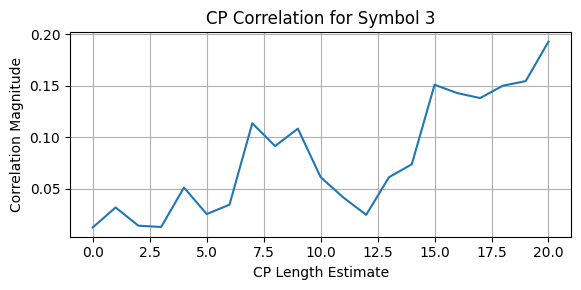

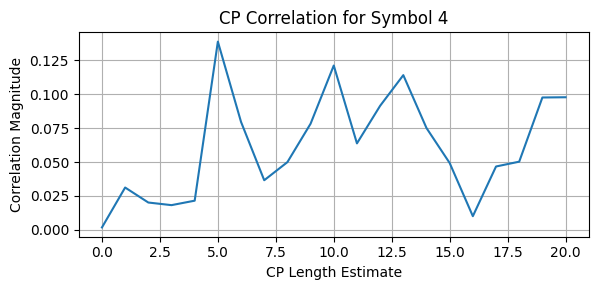

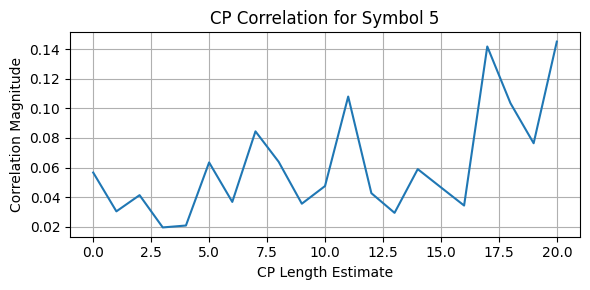

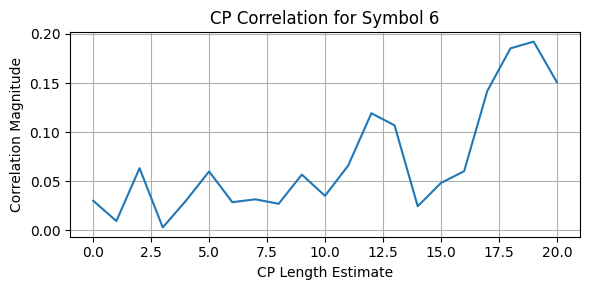

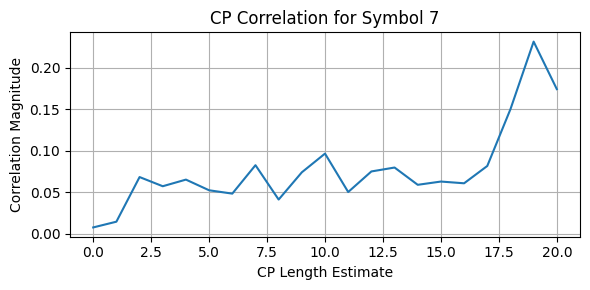

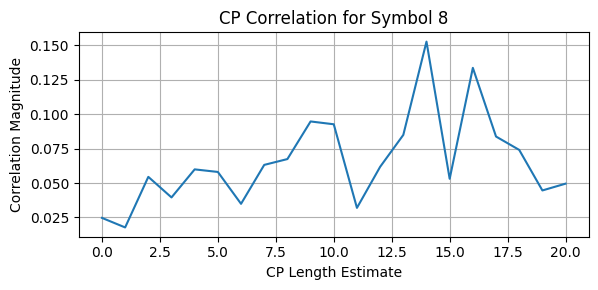

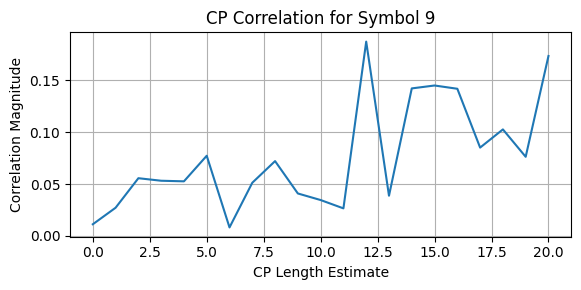

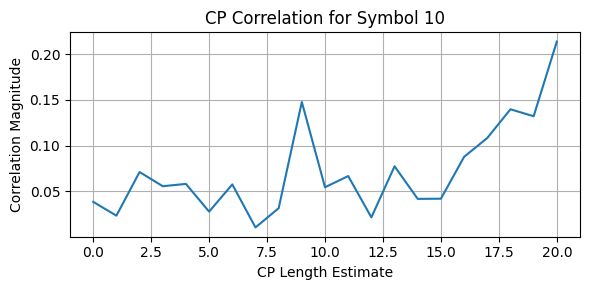

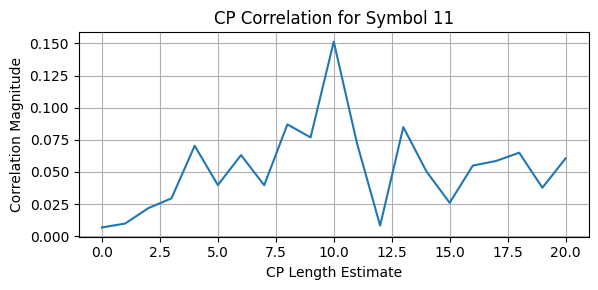

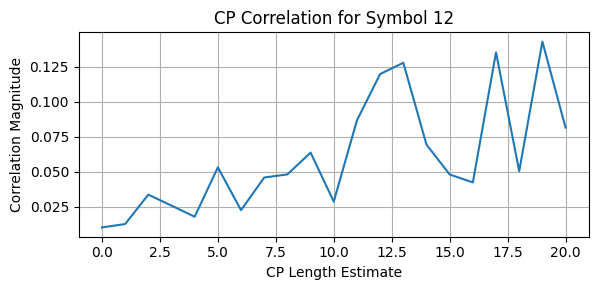

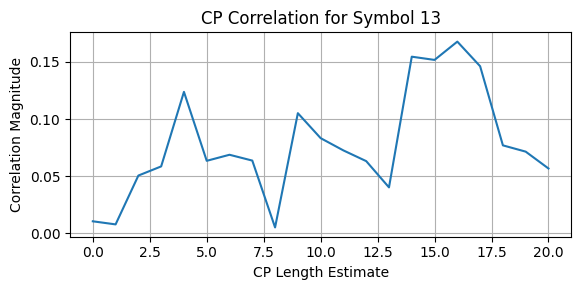

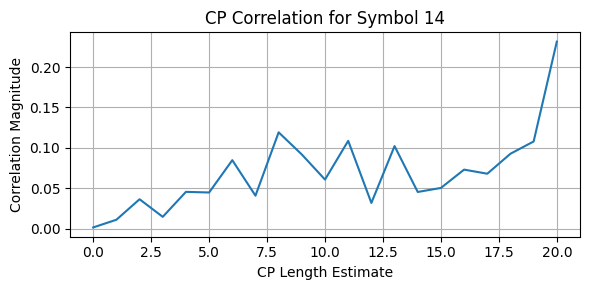

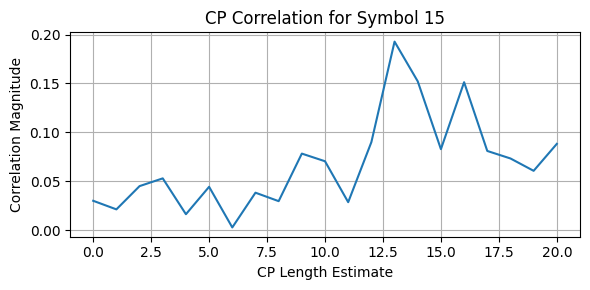

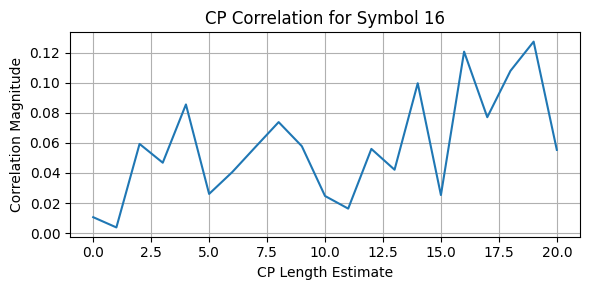

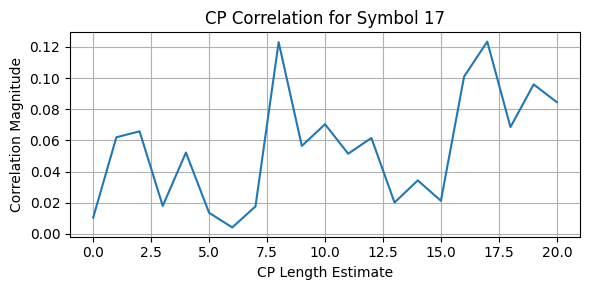

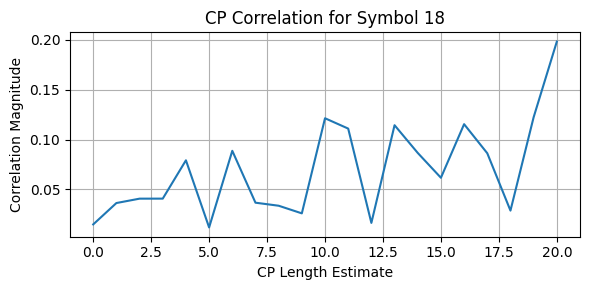

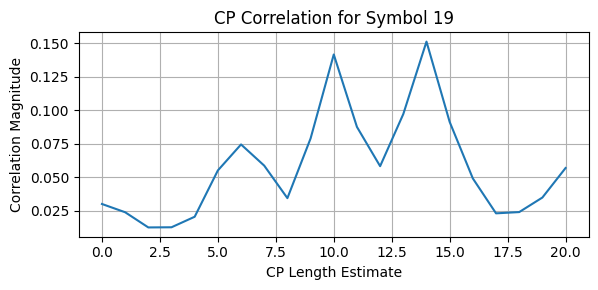

Max averaged CP correlation: 0.1111


In [52]:
start_index = 3025
x = Signal[start_index:]
c = np.zeros((Ld // 4, 19))  # Rows: CP lengths, Cols: symbol instances (3 to 20)

# Process each symbol index from 3 to 20
for i in range(3, 20):
    for cp_length_est in range(1, Ld // 4 + 1):
        Td = cp_length_est + Ld  # Total duration of one symbol with CP
        start = (i - 1) * Td
        end_ = i * Td
        if end_ > len(x):  # Safety check
            continue
        x1 = x[start:end_]
        c[cp_length_est - 1, i - 1] = np.abs(np.sum(np.conj(x1[:cp_length_est]) * x1[-cp_length_est:]))

    # Plot each symbol's CP correlation profile
    plt.figure(figsize=(6, 3))
    plt.plot(c[:, i - 1])
    plt.title(f"CP Correlation for Symbol {i}")
    plt.xlabel("CP Length Estimate")
    plt.ylabel("Correlation Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Average CP correlation across symbols
cp_avg = np.mean(c, axis=1)

# Store maximum correlation (for this fixed start_index)
mm_val = np.max(cp_avg)
print(f"Max averaged CP correlation: {mm_val:.4f}")

### OFDM Symbol Extraction and Constellation Plotting

This process analyzes an OFDM-like signal by segmenting it into symbols, removing cyclic prefixes (CP), performing FFT, and plotting the **constellation diagram** to visualize modulation characteristics.

- Support symbol extraction at different downsampling factors `k`.
- Apply CP removal and FFT per symbol.
- Flatten the frequency-domain symbols into one array.
- Plot the resulting constellation.


### Downsampling and Parameters

For each `k` in `[1, 2, 4, ..., 40]`:

    - Estimated cyclic prefix: `Lcp = 80 / k`
    - Data (useful) length: `Ld = 640 / k`
    - Total symbol duration: `Ls = Lcp + Ld`

We apply optional downsampling by factor `k`:
```python
x = x_raw[::k]


# Mathematical Steps

1. **Symbol Slicing**

   From the signal $x[n]$, we extract an integer number of symbols:

   $$
   \text{total\_length} = \text{num\_symbols} \times L_s
   $$

   Then reshape into matrix $x_{\text{symbols}} \in \mathbb{C}^{L_s \times N_{\text{sym}}}$.

2. **CP Removal**

   Remove first `Lcp` samples of each symbol:

   $$
   x_{\text{no\_cp}} = x_{\text{symbols}}[L_{\text{cp}}:, :]
   $$

3. **FFT per Symbol**

   Apply FFT to each column (symbol):

   $$
   X_k = \text{FFT}(x_{\text{no\_cp}}[:, k])
   $$

4. **FFT Shift**

   Center the DC component using `fftshift`.

5. **Flatten Constellation**

   Flatten all subcarriers from all symbols:

   $$
   \text{constellation\_points} = \text{flatten}(X_{\text{symbols}})
   $$

Processing for k = 1
  Lcp = 0, Ld = 86, Ls = 86
  Start index = 3024


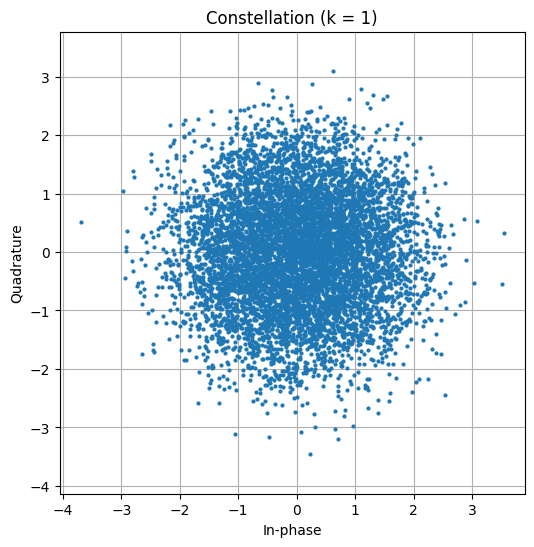

In [ ]:
x_raw = rx_signal

# Optional: visualize multiple downsampling factors
for k in [1]:  # You can extend to [1, 2, 4, 5, 8, 10, 16, 20, 40]
    print(f"Processing for k = {k}")
    
    Lcp = int(0.13 / k)
    Ld = int(86 / k)
    Ls = Lcp + Ld  # Total symbol length
    print(f"  Lcp = {Lcp}, Ld = {Ld}, Ls = {Ls}")

    # Optional: downsampling
    x = x_raw[::k]

    for indd in [3024]:
        print(f"  Start index = {indd}")
        x = x_raw[indd:]
        N = len(x)
        num_symbols = 86  # Fixed manually
        total_length = num_symbols * Ls

        if total_length > N:
            print("  Not enough data to extract symbols.")
            continue

        x_truncated = x[:total_length]

        # Reshape into symbols: shape = (Ls, num_symbols)
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')

        # Remove CP from each symbol (result: shape = (Ld, num_symbols))
        x_no_cp = x_symbols[Lcp:, :]

        # Perform FFT on each column (along rows)
        X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)

        # Shift frequency spectrum (zero-freq to center)
        X_symbols = np.fft.fftshift(X_symbols, axes=0)

        # Flatten to 1D vector
        constellation_points = X_symbols.flatten()

        # Plot the constellation
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k = {k})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.show()